In [14]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t, johnsonsu
import scipy.stats as stats
import requests
from io import BytesIO, StringIO
from zipfile import ZipFile
import properscoring as ps
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Step 1: Download data from Ken French's website
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
response = requests.get(url)

with ZipFile(BytesIO(response.content)) as zfile:
    with zfile.open('F-F_Research_Data_Factors.CSV') as file:
        csv_data = pd.read_csv(file, skiprows=3, index_col=0)

# Convert the data to numeric format and drop rows with missing values
csv_data = csv_data.apply(pd.to_numeric, errors='coerce').dropna()

# Keep only the monthly observations
csv_data = csv_data[csv_data.index.map(lambda x: x.isdigit() and len(x) == 6)]


In [16]:
csv_data.head(10)

,Mkt-RF,SMB,HML,RF
192607,2.96,-2.56,-2.43,0.22
192608,2.64,-1.17,3.82,0.25
192609,0.36,-1.40,0.13,0.23
192610,-3.24,-0.09,0.70,0.32
192611,2.53,-0.10,-0.51,0.31
192612,2.62,-0.03,-0.05,0.28
192701,-0.06,-0.37,4.54,0.25
192702,4.18,0.04,2.94,0.26
192703,0.13,-1.65,-2.61,0.30
192704,0.46,0.30,0.81,0.25


In [17]:
csv_data.tail(10)

,Mkt-RF,SMB,HML,RF
202305,0.35,1.61,-7.72,0.36
202306,6.46,1.54,-0.26,0.40
202307,3.21,2.08,4.11,0.45
202308,-2.39,-3.16,-1.06,0.45
202309,-5.24,-2.51,1.52,0.43
202310,-3.19,-3.87,0.19,0.47
202311,8.84,-0.02,1.64,0.44
202312,4.87,6.34,4.93,0.43
202401,0.71,-5.09,-2.38,0.47
202402,5.06,-0.24,-3.48,0.42


In [18]:
# Step 2: Compute m
csv_data['m'] = (csv_data['Mkt-RF']/100) / (1 + csv_data['RF']/100)

# Step 3: Split data into folds
fold1 = csv_data.loc['192607':'198312']
fold2 = csv_data.loc['198301':'201212']
fold3 = csv_data.loc['201301':'201812']
fold4 = csv_data.loc['201901':]

In [19]:
len(fold1), len(fold2)

(690, 360)

In [20]:
# Step 4: Fit models to fold1
m1 = fold1['m']
params_normal = norm.fit(m1)
params_t = t.fit(m1)
params_johnsonsu = johnsonsu.fit(m1)

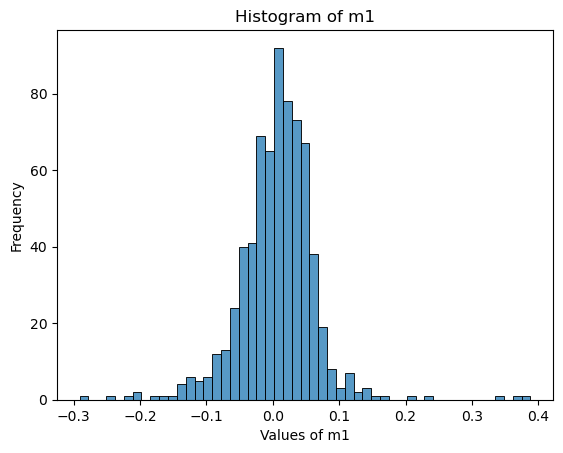

In [21]:
sns.histplot(m1, kde=False)  # Set kde to True if you also want a kernel density estimate overlay

plt.title('Histogram of m1')
plt.xlabel('Values of m1')
plt.ylabel('Frequency')

plt.show()

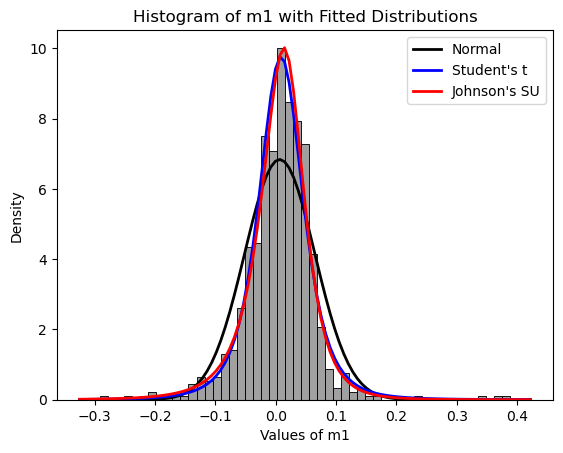

In [22]:
import warnings
warnings.filterwarnings("ignore")
# Create the histogram using Seaborn
sns.histplot(m1, kde=False, color="gray", stat="density")  # Use stat="density" to normalize histogram

# Plot the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_normal = stats.norm.pdf(x, *params_normal)
plt.plot(x, p_normal, 'k', linewidth=2, label='Normal')

# Plot the fitted t distribution
p_t = stats.t.pdf(x, *params_t)
plt.plot(x, p_t, 'b', linewidth=2, label="Student's t")

# Plot the fitted Johnson's SU distribution
p_johnsonsu = stats.johnsonsu.pdf(x, *params_johnsonsu)
plt.plot(x, p_johnsonsu, 'r', linewidth=2, label="Johnson's SU")

plt.title('Histogram of m1 with Fitted Distributions')
plt.xlabel('Values of m1')
plt.ylabel('Density')
plt.legend()

plt.show()

In [23]:
# Step 5: Select among the three models using CRPS on fold2
m2 = fold2['m']

crps_normal = np.mean(ps.crps_ensemble(m2, norm.rvs(*params_normal, size=len(m2))))
crps_t = np.mean(ps.crps_ensemble(m2, t.rvs(*params_t, size=len(m2))))
crps_johnsonsu = np.mean(ps.crps_ensemble(m2, johnsonsu.rvs(*params_johnsonsu, size=len(m2))))

In [29]:
print("Model: Normal")
print(f"Fitted parameters: {params_normal}")

Model: Normal
Fitted parameters: (0.006507298842362819, 0.05834076858095716)


In [30]:
print("Model: Student t")
print(f"Fitted parameters: {params_t}")

Model: Student t
Fitted parameters: (3.4521298217216843, 0.008635493468786549, 0.03801716366296638)


In [31]:
print("Model: Johnson Su")
print(f"Fitted parameters: {params_johnsonsu}")

Model: Johnson Su
Fitted parameters: (0.2614592414070789, 1.2569885504877325, 0.019828128751912005, 0.04937580596273001)


In [32]:
# Step 6: Report the best model and the fitted parameters
best_model = min([(crps_normal, 'Normal', params_normal),
                  (crps_t, 'Student t', params_t),
                  (crps_johnsonsu, 'Johnson Su', params_johnsonsu)], key=lambda x: x[0])

print(f"Best model: {best_model[1]}")
# print(f"Fitted parameters: {best_model[2]}")

Best model: Student t


In [48]:
# Step 7: Compute PIT values for the chosen model on fold 2
if best_model[1] == 'Normal':
    cdf_values = norm.cdf(m2, *params_normal)
elif best_model[1] == 'Student t':
    cdf_values = t.cdf(m2, *params_t)
elif best_model[1] == 'Johnson Su':
    cdf_values = johnsonsu.cdf(m2, *params_johnsonsu)

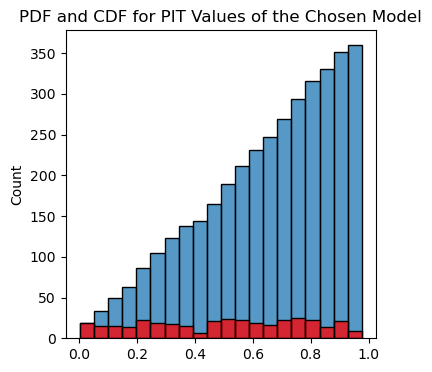

In [49]:
# Step 8: Plot PIT values
plt.figure(figsize=(4, 4))

sns.histplot(cdf_values, bins=20, cumulative=True, alpha=0.75)
sns.histplot(cdf_values, bins=20, color='red', alpha=0.75)
plt.title('PDF and CDF for PIT Values of the Chosen Model')

plt.show()